
## Import Libraries



In [22]:
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split

import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ResNet50V2, DenseNet121
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, AveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD

from keras.wrappers.scikit_learn import KerasClassifier


## Data Preprocessing

In [3]:
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Filter for the classes we want (Cat, Dog, Airplane, Automobile)
selected_classes = [3, 5, 0, 1]  # 3: cat, 5: dog, 0: airplane, 1: automobile in the original dataset

# Create masks for train and test datasets
train_mask = np.isin(train_labels, selected_classes).reshape(-1)
test_mask = np.isin(test_labels, selected_classes).reshape(-1)

# Apply masks to datasets
train_images, train_labels = train_images[train_mask], train_labels[train_mask]
test_images, test_labels = test_images[test_mask], test_labels[test_mask]

# Map the labels to our new labels, no one-hot encoding here
label_dict = {3: 0, 5: 1, 0: 2, 1: 3}
train_labels = np.array([label_dict[label[0]] for label in train_labels])
test_labels = np.array([label_dict[label[0]] for label in test_labels])

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Perform one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

# Split the training data into training and validation data
val_split = 0.2
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=val_split)

# Define data augmentation
datagen_train = ImageDataGenerator(
    vertical_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
)

# Define the batch size
BATCH_SIZE = 200

# Compute quantities required for featurewise normalization (on training data only)
datagen_train.fit(train_images)

train_gen = datagen_train.flow(train_images, train_labels, batch_size=BATCH_SIZE)

# For the validation set, we only normalize the data
datagen_val = ImageDataGenerator()
datagen_val.fit(val_images)
val_gen = datagen_val.flow(val_images, val_labels, batch_size=BATCH_SIZE)

# For the test set, we only normalize the data
datagen_test = ImageDataGenerator()
datagen_test.fit(test_images)
test_gen = datagen_test.flow(test_images, test_labels, batch_size=BATCH_SIZE)

# Calculate steps_per_epoch for training data
steps_per_epoch = train_images.shape[0] // BATCH_SIZE

# Calculate validation_steps for validation data
validation_steps = val_images.shape[0] // BATCH_SIZE

# Calculate test_steps for test data
test_steps = test_images.shape[0] // BATCH_SIZE


#### Distribution

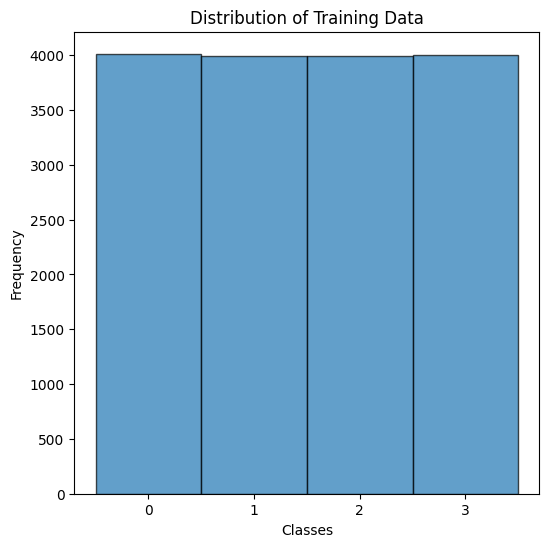

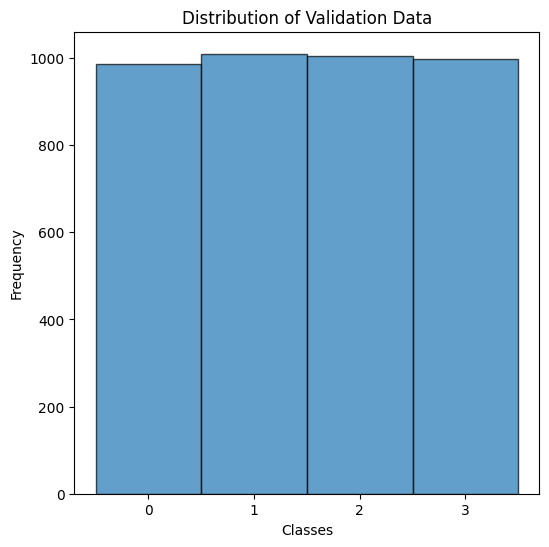

In [3]:

# Converting one-hot encoded labels back to original form for the sake of plotting
train_labels_original = np.argmax(train_labels, axis=1)
val_labels_original = np.argmax(val_labels, axis=1)

# Plotting the distribution of training data
plt.figure(figsize=(6,6))
plt.hist(train_labels_original, bins=np.arange(5)-0.5, edgecolor='black', alpha=0.7)
plt.xticks(np.unique(train_labels_original))
plt.title('Distribution of Training Data')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

# Plotting the distribution of validation data
plt.figure(figsize=(6,6))
plt.hist(val_labels_original, bins=np.arange(5)-0.5, edgecolor='black', alpha=0.7)
plt.xticks(np.unique(val_labels_original))
plt.title('Distribution of Validation Data')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()


## Modeling

### Baseline CNN

In [65]:
# Model architecture
cnn_model = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), 
    Dense(4, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

# Train the model using data augmentation generator
cnn_history = cnn_model.fit(train_gen, steps_per_epoch=steps_per_epoch,
                        epochs=50, validation_data=val_gen, validation_steps=validation_steps)

# Save model
cnn_model.save('cnn1.h5')

Epoch 1/50
100/100 [==============================] - 14s 137ms/step - loss: 1.0688 - accuracy: 0.4921 - val_loss: 0.8050 - val_accuracy: 0.6338
Epoch 2/50
100/100 [==============================] - 14s 135ms/step - loss: 0.8413 - accuracy: 0.6116 - val_loss: 0.7238 - val_accuracy: 0.6597
Epoch 3/50
100/100 [==============================] - 14s 137ms/step - loss: 0.7733 - accuracy: 0.6475 - val_loss: 0.7297 - val_accuracy: 0.6722
Epoch 4/50
100/100 [==============================] - 13s 135ms/step - loss: 0.7598 - accuracy: 0.6614 - val_loss: 0.6564 - val_accuracy: 0.7107
Epoch 5/50
100/100 [==============================] - 13s 134ms/step - loss: 0.7003 - accuracy: 0.6911 - val_loss: 0.6706 - val_accuracy: 0.7023
Epoch 6/50
100/100 [==============================] - 13s 134ms/step - loss: 0.6701 - accuracy: 0.7059 - val_loss: 0.6225 - val_accuracy: 0.7228
Epoch 7/50
100/100 [==============================] - 13s 134ms/step - loss: 0.6426 - accuracy: 0.7218 - val_loss: 0.6594 - val_ac

Evaluate Model

In [67]:
# First, get the probabilities
test_pred_probs = cnn_model.predict(test_images)

# Then, convert the probabilities to class labels
test_pred_classes = np.argmax(test_pred_probs, axis=1)

# Extract the true labels from the test generator
test_true_classes = np.argmax(test_labels, axis=1)

# Getting the classification report
print("CNN Classification Report:\n", classification_report(test_true_classes, test_pred_classes))

# Calculating ROC AUC
roc_auc = roc_auc_score(to_categorical(test_true_classes), test_pred_probs, multi_class='ovr')
print("CNN AUC:", roc_auc)

# Getting the confusion matrix
conf_mat = confusion_matrix(test_true_classes, test_pred_classes)
print("CNN Confusion Matrix:\n", conf_mat)


125/125 [==============================] - 1s 9ms/step
CNN Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.71      0.72      1000
           1       0.77      0.71      0.74      1000
           2       0.88      0.93      0.90      1000
           3       0.92      0.96      0.94      1000

    accuracy                           0.83      4000
   macro avg       0.82      0.83      0.83      4000
weighted avg       0.82      0.83      0.83      4000

CNN AUC: 0.9630776666666666
CNN Confusion Matrix:
 [[707 203  57  33]
 [225 714  48  13]
 [ 26   6 927  41]
 [ 10   5  22 963]]


In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential

INPUT_SHAPE = (32, 32, 3)
KERNEL_SIZE = (3, 3)

cnn_model = Sequential([
    Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(4, activation='softmax')
])


# Compile the model
cnn_model.compile(optimizer=Adam(),
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=7)


# Train the model using data augmentation generator
cnn_history = cnn_model.fit(train_gen,
                        epochs=50, 
                        validation_data=val_gen,
                        callbacks=[reduce_lr, early_stopping],
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=validation_steps
                        ) 

# Save model
cnn_model.save('cnn.h5')


Epoch 1/50
80/80 [==============================] - 19s 225ms/step - loss: 1.0954 - accuracy: 0.5599 - val_loss: 1.6256 - val_accuracy: 0.2637 - lr: 0.0010
Epoch 2/50
80/80 [==============================] - 18s 223ms/step - loss: 0.7830 - accuracy: 0.6492 - val_loss: 2.0316 - val_accuracy: 0.2828 - lr: 0.0010
Epoch 3/50
80/80 [==============================] - 18s 224ms/step - loss: 0.7325 - accuracy: 0.6722 - val_loss: 1.7595 - val_accuracy: 0.3935 - lr: 0.0010
Epoch 4/50
80/80 [==============================] - 18s 226ms/step - loss: 0.6888 - accuracy: 0.6928 - val_loss: 1.6314 - val_accuracy: 0.4383 - lr: 0.0010
Epoch 5/50
80/80 [==============================] - 18s 223ms/step - loss: 0.6628 - accuracy: 0.7069 - val_loss: 1.4015 - val_accuracy: 0.4888 - lr: 0.0010
Epoch 6/50
80/80 [==============================] - 18s 226ms/step - loss: 0.6227 - accuracy: 0.7226 - val_loss: 1.2022 - val_accuracy: 0.5530 - lr: 0.0010
Epoch 7/50
80/80 [==============================] - 18s 225ms/st

Evaluate the model


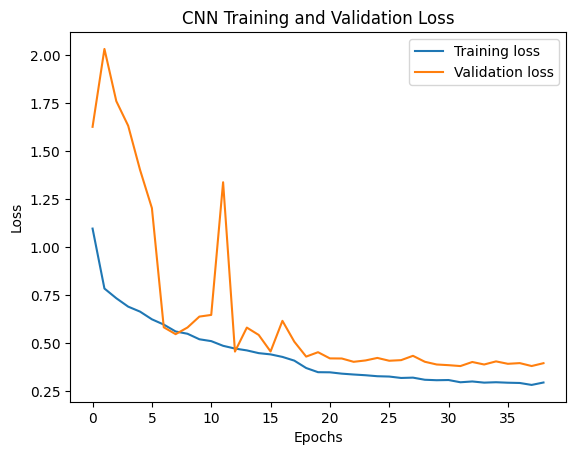

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [8]:
# Load model
cnn_model = load_model('cnn.h5')

# Plotting the training and validation loss
plt.plot(cnn_history.history['loss'], label='Training loss')
plt.plot(cnn_history.history['val_loss'], label='Validation loss')
plt.title('CNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Printing the model summary
cnn_model.summary()

# First, get the probabilities
test_pred_probs = cnn_model.predict(test_images)

# Then, convert the probabilities to class labels
test_pred_classes = np.argmax(test_pred_probs, axis=1)

# Extract the true labels from the test generator
test_true_classes = np.argmax(test_labels, axis=1)

# Getting the classification report
print("CNN Classification Report:\n", classification_report(test_true_classes, test_pred_classes))

# Calculating ROC AUC
roc_auc = roc_auc_score(to_categorical(test_true_classes), test_pred_probs, multi_class='ovr')
print("CNN AUC:", roc_auc)

# Getting the confusion matrix
conf_mat = confusion_matrix(test_true_classes, test_pred_classes)
print("CNN Confusion Matrix:\n", conf_mat)


DenseNet121

In [ ]:

# Load pre-trained model
base_model_DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Unfreeze the last few layers for fine-tuning
for layer in base_model_DenseNet121.layers[:-50]:
    layer.trainable = False

# Add custom layers
x = base_model_DenseNet121.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

# Define the model for training
model_DenseNet121 = Model(inputs=base_model_DenseNet121.input, outputs=predictions)

# Compile the model
model_DenseNet121.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)  # stops training when the model is not improving on the validation set
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)  # reduces the learning rate when the model is not improving on the validation set

# Fit the model
dn_history = model_DenseNet121.fit(train_gen, 
                                validation_data=val_gen, 
                                epochs=100, 
                                validation_steps=validation_steps, 
                                steps_per_epoch=steps_per_epoch, 
                                callbacks=[early_stopping, reduce_lr])


Epoch 1/100
80/80 [==============================] - 22s 218ms/step - loss: 0.9143 - accuracy: 0.6449 - val_loss: 0.6664 - val_accuracy: 0.7163 - lr: 0.0010
Epoch 2/100
80/80 [==============================] - 15s 193ms/step - loss: 0.6491 - accuracy: 0.7297 - val_loss: 0.5936 - val_accuracy: 0.7487 - lr: 0.0010
Epoch 3/100
80/80 [==============================] - 16s 196ms/step - loss: 0.5866 - accuracy: 0.7579 - val_loss: 0.5959 - val_accuracy: 0.7467 - lr: 0.0010
Epoch 4/100
80/80 [==============================] - 15s 193ms/step - loss: 0.5390 - accuracy: 0.7756 - val_loss: 0.5482 - val_accuracy: 0.7653 - lr: 0.0010
Epoch 5/100
80/80 [==============================] - 16s 197ms/step - loss: 0.5131 - accuracy: 0.7911 - val_loss: 0.5639 - val_accuracy: 0.7625 - lr: 0.0010
Epoch 6/100
80/80 [==============================] - 16s 198ms/step - loss: 0.4883 - accuracy: 0.7954 - val_loss: 0.5594 - val_accuracy: 0.7670 - lr: 0.0010
Epoch 7/100
80/80 [==============================] - 15s 1

Evaluate model

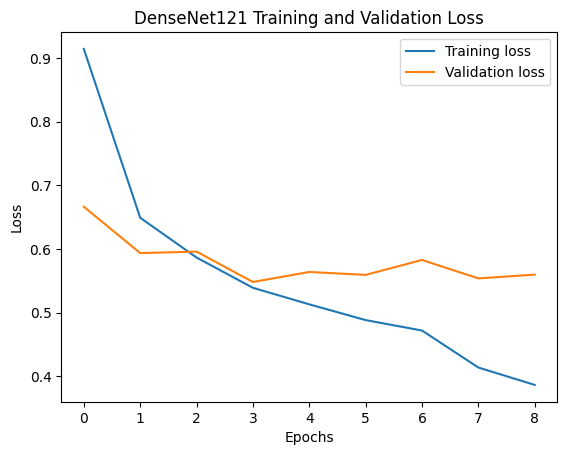

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 38, 38, 3)   0           ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 16, 16, 64)   9408        ['zero_padding2d_4[0][0]']       
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1/conv[0][0]']       

In [ ]:
# Plotting the training and validation loss
plt.plot(dn_history.history['loss'], label='Training loss')
plt.plot(dn_history.history['val_loss'], label='Validation loss')
plt.title('DenseNet121 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Printing the model summary
model_DenseNet121.summary()

# First, get the probabilities
test_pred_probs = model_DenseNet121.predict(test_images)

# Then, convert the probabilities to class labels
test_pred_classes = np.argmax(test_pred_probs, axis=1)

# Extract the true labels from the test generator
test_true_classes = np.argmax(test_labels, axis=1)

# Getting the classification report
print("Resnet50v2 Classification Report:\n", classification_report(test_true_classes, test_pred_classes))

# Calculating ROC AUC
roc_auc = roc_auc_score(to_categorical(test_true_classes), test_pred_probs, multi_class='ovr')
print("Resnet50v2 AUC:", roc_auc)

# Getting the confusion matrix
conf_mat = confusion_matrix(test_true_classes, test_pred_classes)
print("Resnet50v2 Confusion Matrix:\n", conf_mat)


### Resnet

In [6]:

# Model architecture
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add a new top layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(4, activation='softmax')(x)

# this is the model we will train
res_model = Model(inputs=base_model.input, outputs=predictions)

# first, we only train the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
res_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model using data augmentation generator
res_history = res_model.fit(train_gen,
                        steps_per_epoch=steps_per_epoch,
                        epochs=10, 
                        validation_data=val_gen,
                        validation_steps=validation_steps)

# Save model
res_model.save('resnet.h5')


Epoch 1/10
80/80 [==============================] - 16s 180ms/step - loss: 1.4230 - accuracy: 0.3246 - val_loss: 1.2865 - val_accuracy: 0.4512
Epoch 2/10
80/80 [==============================] - 14s 173ms/step - loss: 1.2481 - accuracy: 0.4669 - val_loss: 1.2119 - val_accuracy: 0.4593
Epoch 3/10
80/80 [==============================] - 14s 173ms/step - loss: 1.1921 - accuracy: 0.4705 - val_loss: 1.1634 - val_accuracy: 0.4888
Epoch 4/10
80/80 [==============================] - 14s 174ms/step - loss: 1.1672 - accuracy: 0.4786 - val_loss: 1.1568 - val_accuracy: 0.4655
Epoch 5/10
80/80 [==============================] - 14s 176ms/step - loss: 1.1436 - accuracy: 0.4887 - val_loss: 1.1129 - val_accuracy: 0.5203
Epoch 6/10
80/80 [==============================] - 14s 178ms/step - loss: 1.1358 - accuracy: 0.4914 - val_loss: 1.1052 - val_accuracy: 0.5045
Epoch 7/10
80/80 [==============================] - 14s 176ms/step - loss: 1.1167 - accuracy: 0.5045 - val_loss: 1.0988 - val_accuracy: 0.5050

Evaluate the model

In [7]:
# Save model
res_model = load_model('resnet.h5')

# First, get the probabilities
test_pred_probs = res_model.predict(test_images)

# Then, convert the probabilities to class labels
test_pred_classes = np.argmax(test_pred_probs, axis=1)

# Extract the true labels from the test generator
test_true_classes = np.argmax(test_labels, axis=1)

# Getting the classification report
print("ResNet Classification Report:\n", classification_report(test_true_classes, test_pred_classes))

# Calculating ROC AUC
roc_auc = roc_auc_score(to_categorical(test_true_classes), test_pred_probs, multi_class='ovr')
print("ResNet AUC:", roc_auc)

# Getting the confusion matrix
conf_mat = confusion_matrix(test_true_classes, test_pred_classes)
print("ResNet Confusion Matrix:\n", conf_mat)


125/125 [==============================] - 6s 45ms/step
ResNet Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.26      0.33      1000
           1       0.50      0.55      0.53      1000
           2       0.55      0.75      0.63      1000
           3       0.64      0.61      0.62      1000

    accuracy                           0.54      4000
   macro avg       0.54      0.54      0.53      4000
weighted avg       0.54      0.54      0.53      4000

ResNet AUC: 0.8052117083333332
ResNet Confusion Matrix:
 [[262 388 226 124]
 [209 554 155  82]
 [ 45  65 747 143]
 [ 61  99 227 613]]


### LeNet-5

In [10]:


# Model architecture
lenet_model = Sequential([
    Conv2D(6, (5, 5), activation='tanh', input_shape=(32, 32, 3), padding='same'),
    AveragePooling2D(),
    Conv2D(16, (5, 5), activation='tanh', padding='valid'),
    AveragePooling2D(),
    Flatten(),
    Dense(120, activation='tanh'),
    Dense(84, activation='tanh'),
    Dense(4, activation='softmax')
])

# Compile the model
lenet_model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])


# Train the model using data augmentation generator
lenet_history = lenet_model.fit(train_gen,
                        steps_per_epoch=steps_per_epoch,
                        epochs=50, 
                        validation_data=val_gen,
                        validation_steps=validation_steps)

# Save model
lenet_model.save('lenet.h5')


Epoch 1/50
80/80 [==============================] - 4s 41ms/step - loss: 1.2145 - accuracy: 0.4436 - val_loss: 1.1210 - val_accuracy: 0.5263
Epoch 2/50
80/80 [==============================] - 3s 40ms/step - loss: 1.1110 - accuracy: 0.5139 - val_loss: 1.0698 - val_accuracy: 0.5418
Epoch 3/50
80/80 [==============================] - 3s 40ms/step - loss: 1.0649 - accuracy: 0.5376 - val_loss: 1.0457 - val_accuracy: 0.5497
Epoch 4/50
80/80 [==============================] - 3s 40ms/step - loss: 1.0260 - accuracy: 0.5564 - val_loss: 0.9936 - val_accuracy: 0.5655
Epoch 5/50
80/80 [==============================] - 3s 40ms/step - loss: 0.9899 - accuracy: 0.5683 - val_loss: 0.9367 - val_accuracy: 0.5957
Epoch 6/50
80/80 [==============================] - 3s 40ms/step - loss: 0.9482 - accuracy: 0.5866 - val_loss: 0.9141 - val_accuracy: 0.6075
Epoch 7/50
80/80 [==============================] - 3s 40ms/step - loss: 0.9156 - accuracy: 0.5963 - val_loss: 0.8727 - val_accuracy: 0.6137
Epoch 8/50
80

Evaluate the model

In [11]:
# First, get the probabilities
test_pred_probs = lenet_model.predict(test_images)

# Then, convert the probabilities to class labels
test_pred_classes = np.argmax(test_pred_probs, axis=1)

# Extract the true labels from the test generator
test_true_classes = np.argmax(test_labels, axis=1)

# Getting the classification report
print("LeNet Classification Report:\n", classification_report(test_true_classes, test_pred_classes))

# Calculating ROC AUC
roc_auc = roc_auc_score(to_categorical(test_true_classes), test_pred_probs, multi_class='ovr')
print("LeNet AUC:", roc_auc)

# Getting the confusion matrix
conf_mat = confusion_matrix(test_true_classes, test_pred_classes)
print("LeNet Confusion Matrix:\n", conf_mat)


125/125 [==============================] - 0s 2ms/step
LeNet Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.49      0.54      1000
           1       0.59      0.68      0.63      1000
           2       0.81      0.80      0.81      1000
           3       0.82      0.85      0.83      1000

    accuracy                           0.71      4000
   macro avg       0.71      0.71      0.70      4000
weighted avg       0.71      0.71      0.70      4000

LeNet AUC: 0.9034395000000001
LeNet Confusion Matrix:
 [[491 383  69  57]
 [233 683  46  38]
 [ 56  51 802  91]
 [ 42  38  71 849]]


### VGG-16

In [19]:

# Model architecture
vgg_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes
])

# Compile the model
vgg_model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

# Replace these with your actual generators
# Train the model using data augmentation generator
vgg_history = vgg_model.fit(train_gen,
                            steps_per_epoch=steps_per_epoch,
                            epochs=100, 
                            validation_data=val_gen,
                            validation_steps=validation_steps)

# Save model
vgg_model.save('vgg.h5')


Epoch 1/100
80/80 [==============================] - 9s 104ms/step - loss: 1.0952 - accuracy: 0.4754 - val_loss: 0.9019 - val_accuracy: 0.5882
Epoch 2/100
80/80 [==============================] - 8s 101ms/step - loss: 0.8336 - accuracy: 0.6014 - val_loss: 0.7830 - val_accuracy: 0.6438
Epoch 3/100
80/80 [==============================] - 8s 102ms/step - loss: 0.7733 - accuracy: 0.6421 - val_loss: 0.8132 - val_accuracy: 0.6367
Epoch 4/100
80/80 [==============================] - 8s 101ms/step - loss: 0.7216 - accuracy: 0.6736 - val_loss: 0.6061 - val_accuracy: 0.7285
Epoch 5/100
80/80 [==============================] - 8s 102ms/step - loss: 0.6836 - accuracy: 0.6957 - val_loss: 0.5929 - val_accuracy: 0.7308
Epoch 6/100
80/80 [==============================] - 8s 101ms/step - loss: 0.6457 - accuracy: 0.7114 - val_loss: 0.5723 - val_accuracy: 0.7433
Epoch 7/100
80/80 [==============================] - 8s 101ms/step - loss: 0.6114 - accuracy: 0.7298 - val_loss: 0.5446 - val_accuracy: 0.7555

Evaluate the model

In [21]:
# First, get the probabilities
test_pred_probs = vgg_model.predict(test_images)

# Then, convert the probabilities to class labels
test_pred_classes = np.argmax(test_pred_probs, axis=1)

# Extract the true labels from the test generator
test_true_classes = np.argmax(test_labels, axis=1)

# Getting the classification report
print("VGG Classification Report:\n", classification_report(test_true_classes, test_pred_classes))

# Calculating ROC AUC
roc_auc = roc_auc_score(to_categorical(test_true_classes), test_pred_probs, multi_class='ovr')
print("VGG AUC:", roc_auc)

# Getting the confusion matrix
conf_mat = confusion_matrix(test_true_classes, test_pred_classes)
print("VGG Confusion Matrix:\n", conf_mat)


125/125 [==============================] - 1s 4ms/step
VGG Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.71      0.73      1000
           1       0.77      0.76      0.77      1000
           2       0.90      0.92      0.91      1000
           3       0.92      0.95      0.94      1000

    accuracy                           0.84      4000
   macro avg       0.84      0.84      0.84      4000
weighted avg       0.84      0.84      0.84      4000

VGG AUC: 0.9644812916666667
VGG Confusion Matrix:
 [[713 208  51  28]
 [203 762  23  12]
 [ 32   7 922  39]
 [ 11   8  27 954]]


#### ResNet50V2

In [25]:


# Load the ResNet50V2 model with pre-trained weights and without the top layers
Resnet50v2_base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of the base model
for layer in Resnet50v2_base_model.layers:
    layer.trainable = False

# Define the model
Resnet50v2_model = Sequential()
Resnet50v2_model.add(Resnet50v2_base_model)
Resnet50v2_model.add(Flatten())
Resnet50v2_model.add(Dense(512, activation='relu'))
Resnet50v2_model.add(Dropout(0.5))
Resnet50v2_model.add(Dense(4, activation='softmax')) # Since you have 4 classes

# Compile the model
Resnet50v2_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Fit the model
Resnet50v2_history = Resnet50v2_model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch, 
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

# Save model
Resnet50v2_model.save('Resnet50v2.h5')


Epoch 1/50
80/80 [==============================] - 13s 139ms/step - loss: 1.3440 - accuracy: 0.3577 - val_loss: 1.2616 - val_accuracy: 0.4660
Epoch 2/50
80/80 [==============================] - 10s 128ms/step - loss: 1.2578 - accuracy: 0.4428 - val_loss: 1.2098 - val_accuracy: 0.4870
Epoch 3/50
80/80 [==============================] - 10s 130ms/step - loss: 1.2045 - accuracy: 0.4766 - val_loss: 1.1765 - val_accuracy: 0.4942
Epoch 4/50
80/80 [==============================] - 10s 130ms/step - loss: 1.1799 - accuracy: 0.4858 - val_loss: 1.1540 - val_accuracy: 0.5045
Epoch 5/50
80/80 [==============================] - 11s 132ms/step - loss: 1.1587 - accuracy: 0.4942 - val_loss: 1.1345 - val_accuracy: 0.5165
Epoch 6/50
80/80 [==============================] - 10s 131ms/step - loss: 1.1349 - accuracy: 0.5104 - val_loss: 1.1189 - val_accuracy: 0.5210
Epoch 7/50
80/80 [==============================] - 10s 128ms/step - loss: 1.1210 - accuracy: 0.5165 - val_loss: 1.1059 - val_accuracy: 0.5290

In [26]:
# First, get the probabilities
test_pred_probs = Resnet50v2_model.predict(test_images)

# Then, convert the probabilities to class labels
test_pred_classes = np.argmax(test_pred_probs, axis=1)

# Extract the true labels from the test generator
test_true_classes = np.argmax(test_labels, axis=1)

# Getting the classification report
print("Resnet50v2 Classification Report:\n", classification_report(test_true_classes, test_pred_classes))

# Calculating ROC AUC
roc_auc = roc_auc_score(to_categorical(test_true_classes), test_pred_probs, multi_class='ovr')
print("Resnet50v2 AUC:", roc_auc)

# Getting the confusion matrix
conf_mat = confusion_matrix(test_true_classes, test_pred_classes)
print("Resnet50v2 Confusion Matrix:\n", conf_mat)


125/125 [==============================] - 5s 37ms/step
Resnet50v2 Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.41      0.46      1000
           1       0.58      0.53      0.55      1000
           2       0.66      0.79      0.72      1000
           3       0.58      0.63      0.60      1000

    accuracy                           0.59      4000
   macro avg       0.58      0.59      0.58      4000
weighted avg       0.58      0.59      0.58      4000

Resnet50v2 AUC: 0.83019975
Resnet50v2 Confusion Matrix:
 [[412 242 149 197]
 [218 526 103 153]
 [ 58  37 794 111]
 [114 100 156 630]]


#### Test Image

In [15]:
def test_image(model, path):
    # Load the image
    img = image.load_img(path, target_size=(32, 32))

    # Convert the image to a numpy array
    x = image.img_to_array(img)

    # Normalize the image
    x = x / 255.0

    # Add a dimension to transform the array into a "batch" of size (1, 32, 32, 3)
    x = np.expand_dims(x, axis=0)

    # Perform the prediction
    preds = model.predict(x)

    # Decode the prediction
    pred_class = np.argmax(preds[0])

    # Map the label index to the corresponding class
    label_map = {0: 'Cat', 1: 'Dog', 2: 'Airplane', 3: 'Automobile'}  # adjust this to your classes
    print(f'The image is classified as: {label_map[pred_class]}')

    imgplot = plt.imshow(img)
    plt.show()

1/1 [==============================] - 0s 16ms/step
The image is classified as: Dog


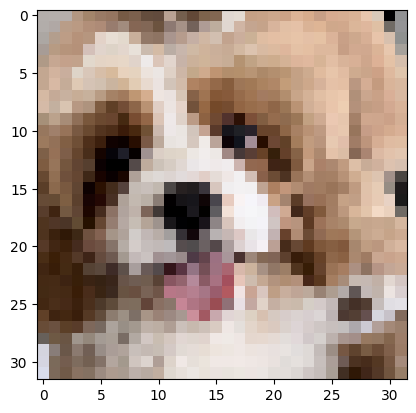

In [16]:
img_path = 'dog.jpg'  # replace with your image path
test_image(cnn_model, img_path)

1/1 [==============================] - 0s 15ms/step
The image is classified as: Cat


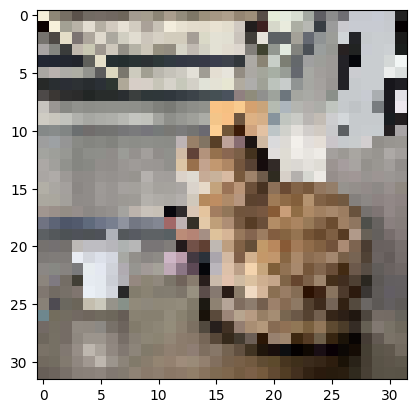

In [17]:
img_path = 'cat1.jpg'  # replace with your image path
test_image(cnn_model, img_path)

1/1 [==============================] - 0s 16ms/step
The image is classified as: Airplane


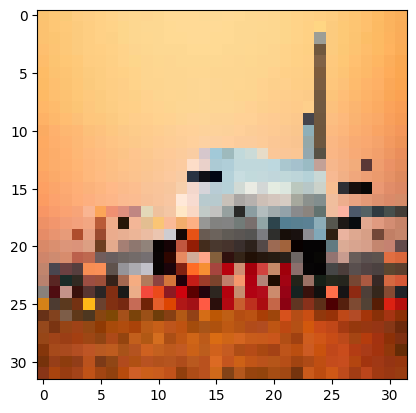

In [19]:
img_path = 'airplane.jpg'  # replace with your image path
test_image(cnn_model, img_path)

1/1 [==============================] - 0s 21ms/step
The image is classified as: Automobile


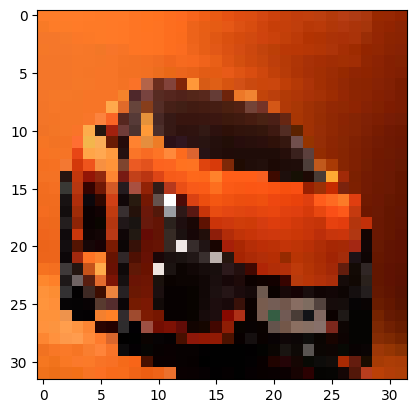

In [20]:
img_path = 'car.jpg'  # replace with your image path
test_image(cnn_model, img_path)